In [ ]:
pip install ray

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import copy
import multiprocessing
import os
import ray
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune.schedulers import ASHAScheduler
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __getitem__(self, index):
        return self.data[index], self.target[index]

    def __len__(self):
        return len(self.data)


In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True
        else:
            self.counter = 0


In [ ]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Inicjalizacja stanu ukrytego LSTM
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Przekazanie danych wejściowych przez warstwę LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Przekazanie ostatniego kroku czasowego przez warstwę Fully Connected
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
def train_fn(config):
  train_loader = DataLoader(config["ds"], batch_size=config["batch_size"], shuffle=False)

  test_dataloader = DataLoader(config["test_ds"], batch_size=config["batch_size"], shuffle=False)

  early_stopping = EarlyStopping(tolerance=config["tolerance"], min_delta=config["min_delta"])

  #model = ConvLSTM(8, 4, (7,7), 1, True, True, False)
  model = LSTMModel(config["input_size"], config["hidden_size"], config["num_layer"], 1)
  model.to(device)
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
  epoch_test_loss = 0

  for epoch in range(config["epoch"]):
      epoch_test_loss = []
      epoch_loss = []
      model.train()
      for batch_x, batch_y in train_loader:
          batch_x = batch_x.to(device)
          batch_y = batch_y.to(device)
          optimizer.zero_grad()
          y_pred = model(batch_x)
          loss = criterion(y_pred, batch_y).to(device)
          loss.backward()
          epoch_loss.append(loss.item())
          optimizer.step()
      epoch_loss = np.mean(epoch_loss)

      model.eval()

      with torch.no_grad():
          for batch_test_x, batch_test_y in test_dataloader:
              batch_test_x = batch_test_x.to(device)
              batch_test_y = batch_test_y.to(device)
              y_test_pred = model(batch_test_x)
              test_loss = criterion(y_test_pred, batch_test_y).to(device)
              epoch_test_loss.append(test_loss.item())
          epoch_test_loss = np.mean(epoch_test_loss)

      early_stopping(epoch_loss, epoch_test_loss)
      if early_stopping.early_stop:
        tune.report(loss = epoch_test_loss)
        break

      #os.makedirs("my_model", exist_ok=True)
      #torch.save((model.state_dict(), optimizer.state_dict()), "my_model/checkpoint.pt")
      #checkpoint = Checkpoint.from_directory("my_model")
      tune.report(loss = epoch_test_loss)



In [ ]:
def test_best_model(best_result):
    best_trained_model = LSTMModel(best_result.config["input_size"], best_result.config["hidden_size"], best_result.config["num_layer"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    test_ds = CustomDataset(test_data_tensor, test_target_tensor)
    test_dataloader = DataLoader(test_ds, batch_size=32, shuffle=False)

    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        for batch_x, batch_y in test_dataloader:
            y_true += batch_y.tolist()
            y_pred += model(batch_x).tolist()
            print(y_pred)
            break
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

In [ ]:
data_path = "/content/drive/MyDrive/master/data"
dataset_path = os.path.join(data_path, "ready_dataset_.pickle")
ds_grace_path = os.path.join(data_path, "ready_grace_dataset.pickle")
ds_297_path = os.path.join(data_path, "ready_dataset_grace_single_297.pickle")

In [ ]:
data = pd.read_pickle(dataset_path)

In [ ]:
data

,target_value,merged
0,0.758333,"[0.40286391973495483, 0.40286391973495483, 0.4..."
1,0.883333,"[0.612511396408081, 0.612511396408081, 0.63432..."
2,0.972222,"[0.7316049337387085, 0.7316049337387085, 0.764..."
3,1.000000,"[0.8035080432891846, 0.8035080432891846, 0.806..."
4,0.947222,"[0.9123387336730957, 0.9123387336730957, 0.912..."
...,...,...
85,0.483333,"[0.3601520359516144, 0.3601520359516144, 0.354..."
86,0.338889,"[0.5864202976226807, 0.5864202976226807, 0.588..."
87,0.144444,"[0.7909024357795715, 0.7909024357795715, 0.794..."
88,0.366667,"[0.8571354150772095, 0.8571354150772095, 0.860..."


In [ ]:
data_arr = data.to_numpy()

feat_data = data.loc[:, data.columns != "target_value"]
target_data = data.loc[:, data.columns == "target_value"]

feat_arr = feat_data.to_numpy()
target_arr = target_data.to_numpy()

target_arr = np.array(target_arr, dtype=np.float32).reshape(-1, 1)

In [ ]:
feat_arr.shape

(90, 1)

In [ ]:
#data_arr[0][8]
data_arr_2 = []
for row in feat_arr:
    row = np.vstack(row)
    row_2 = []
    #for item in row:
    #    item = item.reshape(8,13)
    #    row_2.append(item)
    data_arr_2.append(row)



In [ ]:
target_arr_2 = []
for row in target_arr:
    row = np.hstack(row)
    row_2 = []
    for item in row:
        target_arr_2.append(item)

In [ ]:
data_arr_2 = np.array(data_arr_2, dtype=np.float32)
data_flatten = np.array([row.flatten() for row in data_arr_2])

In [ ]:
data_flatten

array([[0.40286392, 0.40286392, 0.4144625 , ..., 0.4146566 , 0.4146566 ,
        0.4146566 ],
       [0.6125114 , 0.6125114 , 0.6343278 , ..., 0.2683324 , 0.2683324 ,
        0.2683324 ],
       [0.73160493, 0.73160493, 0.7645573 , ..., 0.17917337, 0.17917337,
        0.17917337],
       ...,
       [0.79090244, 0.79090244, 0.7946406 , ..., 0.6416968 , 0.6416968 ,
        0.6416968 ],
       [0.8571354 , 0.8571354 , 0.8600404 , ..., 0.6995308 , 0.6995308 ,
        0.6995308 ],
       [0.98882306, 0.98882306, 0.991624  , ..., 0.92073345, 0.92073345,
        0.92073345]], dtype=float32)

In [ ]:
batch_size = 32
seq_len = 4
sequences = []
targets = []
flat_seq = []
flat_targets = []

for i in range(len(data_flatten) - seq_len + 1):
        sequences.append(data_flatten[i:i + seq_len])  # Wyłączenie ostatniej kolumny (target) z sekwencji
        targets.append(np.array([target_arr_2[i + seq_len-1]]))
        flat_seq.append(data_flatten[i:i + seq_len].flatten())  # Wyłączenie ostatniej kolumny (target) z sekwencji
        flat_targets.append(np.array([target_arr_2[i + seq_len-1]]).flatten())

sequences = np.array(sequences, dtype=np.float32)
targets = np.array(targets, dtype=np.float32)

flat_seq = np.array(flat_seq, dtype=np.float32)
flat_targets = np.array(flat_targets, dtype=np.float32)

print(flat_targets.shape)
train_sequences = sequences[:int(sequences.shape[0] * 0.7)]
train_targets = targets[:int(targets.shape[0] * 0.7)]
test_sequences = sequences[int(sequences.shape[0] * 0.7):]
test_targets = targets[int(targets.shape[0] * 0.7):]

train_flat_sequences = flat_seq[:int(flat_seq.shape[0] * 0.7)]
train_flat_targets = flat_targets[:int(flat_targets.shape[0] * 0.7)]
test_flat_sequences = flat_seq[int(flat_seq.shape[0] * 0.7):]
test_flat_targets = flat_targets[int(flat_targets.shape[0] * 0.7):]

data_tensor = torch.tensor(train_sequences, dtype=torch.float32)
target_tensor = torch.tensor(train_targets, dtype=torch.float32)

test_data_tensor = torch.tensor(test_sequences, dtype=torch.float32)
test_target_tensor = torch.tensor(test_targets, dtype=torch.float32)


(87, 1)


In [ ]:
sequences[0].shape

(4, 832)

In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

print(device)

cuda


In [ ]:
ds = CustomDataset(data_tensor, target_tensor)
test_ds = CustomDataset(test_data_tensor, test_target_tensor)

In [ ]:
ray.shutdown()

In [ ]:
config = {
    "batch_size": tune.choice([16, 32, 64]),
    "hidden_size": tune.choice([2 ** i for i in range(9)]),
    "num_layer": tune.choice([1, 2, 3, 4, 5, 6, 7, 8]),
    "epoch": tune.choice([60, 80, 100, 150, 200, 500, 700, 1000]),
    "learning_rate": tune.loguniform(0.005, 0.1),
    "ds": ds,
    "test_ds": test_ds,
    "input_size": 832, #change if you change the input size
    "tolerance": tune.choice([1, 2, 3, 4, 5]),
    "min_delta": tune.choice([1, 2, 3, 5, 10, 15, 20, 25, 30])
}

scheduler = ASHAScheduler(
        max_t=1000,
        grace_period=1,
        reduction_factor=2)

ray.init(object_store_memory=10**10)
tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_fn),
            resources={"cpu": 1, "gpu": 1}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=100,
        ),
        param_space=config,
    )
results = tuner.fit()

best_result = results.get_best_result("loss")

2023-07-09 21:47:26,893	WARNING services.py:1826 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 6101663744 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-07-09 21:47:27,961	INFO worker.py:1636 -- Started a local Ray instance.
2023-07-09 21:47:30,184	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2023-07-09 21:47:31 (running for 00:00:01.11)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 512.000: None | Iter 256.000: None | Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Logical resource usage: 0/2 CPUs, 0/1 GPUs
Result logdir: /root/ray_results/train_fn_2023-07-09_21-47-30
Number of trials: 16/100 (16 PENDING)
+----------------------+----------+-------+--------------+---------+---------------+-----------------+-------------+-------------+-------------+
| Trial name           | status   | loc   |   batch_size |   epoch |   hidden_size |   learning_rate |   min_delta |   num_layer |   tolerance |
|----------------------+----------+-------+--------------+---------+---------------+-----------------+-------------+-------------+-------------|
| train_fn_340c8_00000 | PENDING  |       |           64 |    1000 |           256 |      0.0249397  |     

2023-07-09 21:48:16,402	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 0.681 s, which may be a performance bottleneck.
2023-07-09 21:48:16,403	WARNING util.py:315 -- The `process_trial_result` operation took 0.683 s, which may be a performance bottleneck.
2023-07-09 21:48:16,405	WARNING util.py:315 -- Processing trial results took 0.684 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-07-09 21:48:16,406	WARNING util.py:315 -- The `process_trial_result` operation took 0.685 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-07-09 21:48:16 (running for 00:00:46.57)
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 512.000: -0.0648288894444704 | Iter 256.000: -0.06187822576612234 | Iter 128.000: -0.05930282175540924 | Iter 64.000: -0.08715713396668434 | Iter 32.000: -0.09500441700220108 | Iter 16.000: -0.10298615135252476 | Iter 8.000: -0.1060930248349905 | Iter 4.000: -0.15543796122074127 | Iter 2.000: -0.10458670556545258 | Iter 1.000: -0.18613174557685852
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
Current best trial: 340c8_00021 with loss=0.02847253903746605 and parameters={'batch_size': 32, 'hidden_size': 4, 'num_layer': 3, 'epoch': 1000, 'learning_rate': 0.019453390933782167, 'ds': <__main__.CustomDataset object at 0x7f6fe84b5360>, 'test_ds': <__main__.CustomDataset object at 0x7f6fe85e1480>, 'input_size': 832, 'tolerance': 2, 'min_delta': 25}
Result logdir: /root/ray_results/train_fn_2023-07-09_21-47-30
Number of trials: 38/100 (16 PENDING, 1 RUNNING, 21 TERMINATED

2023-07-09 21:48:53,802	INFO tune.py:1111 -- Total run time: 83.65 seconds (77.92 seconds for the tuning loop).


== Status ==
Current time: 2023-07-09 21:48:53 (running for 00:01:23.55)
Using AsyncHyperBand: num_stopped=98
Bracket: Iter 512.000: -0.0648288894444704 | Iter 256.000: -0.06187822576612234 | Iter 128.000: -0.09052281826734543 | Iter 64.000: -0.09332925453782082 | Iter 32.000: -0.09515061974525452 | Iter 16.000: -0.09637188911437988 | Iter 8.000: -0.09207047335803509 | Iter 4.000: -0.10598317719995975 | Iter 2.000: -0.06855723634362221 | Iter 1.000: -0.2143552526831627
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
Current best trial: 340c8_00021 with loss=0.043258946388959885 and parameters={'batch_size': 32, 'hidden_size': 4, 'num_layer': 3, 'epoch': 1000, 'learning_rate': 0.019453390933782167, 'ds': <__main__.CustomDataset object at 0x7f6fe84d28c0>, 'test_ds': <__main__.CustomDataset object at 0x7f6fe84b5360>, 'input_size': 832, 'tolerance': 2, 'min_delta': 25}
Result logdir: /root/ray_results/train_fn_2023-07-09_21-47-30
Number of trials: 100/100 (100 TERMINATED)
+-----------------

In [ ]:
best_result

Result(
  metrics={'loss': 0.043258946388959885, 'done': True, 'trial_id': '340c8_00021', 'experiment_tag': '21_batch_size=32,epoch=1000,hidden_size=4,learning_rate=0.0195,min_delta=25,num_layer=3,tolerance=2'},
  path='/root/ray_results/train_fn_2023-07-09_21-47-30/train_fn_340c8_00021_21_batch_size=32,epoch=1000,hidden_size=4,learning_rate=0.0195,min_delta=25,num_layer=3,tolerance=2_2023-07-09_21-47-58',
  checkpoint=None
)

In [ ]:
best_config = best_result.metrics["config"]

In [ ]:
ds = CustomDataset(data_tensor, target_tensor)
test_ds = CustomDataset(test_data_tensor, test_target_tensor)
#weights_path = os.path.join(data_path, "model_best_v1.pt")


old_loss = 99999999999

train_loader = DataLoader(ds, batch_size=best_config["batch_size"], shuffle=False)

test_dataloader = DataLoader(test_ds, batch_size=best_config["batch_size"], shuffle=False)

early_stopping = EarlyStopping(tolerance=best_config["tolerance"], min_delta=best_config["min_delta"])

#model = ConvLSTM(8, 4, (7,7), 1, True, True, False)
model = LSTMModel(best_config["input_size"], best_config["hidden_size"], best_config["num_layer"], 1)
model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_config["learning_rate"])
epoch_test_loss = 0

for epoch in range(best_config["epoch"]):
    epoch_test_loss = []
    epoch_loss = []
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        loss = criterion(y_pred, batch_y).to(device)
        loss.backward()
        epoch_loss.append(loss.item())
        optimizer.step()
    epoch_loss = np.mean(epoch_loss)

    model.eval()

    with torch.no_grad():
        for batch_test_x, batch_test_y in test_dataloader:
            batch_test_x = batch_test_x.to(device)
            batch_test_y = batch_test_y.to(device)
            y_test_pred = model(batch_test_x)
            test_loss = criterion(y_test_pred, batch_test_y).to(device)
            epoch_test_loss.append(test_loss.item())
        epoch_test_loss = np.mean(epoch_test_loss)

    early_stopping(epoch_loss, epoch_test_loss)
    if early_stopping.early_stop:
        break


In [ ]:
test_ds = CustomDataset(test_data_tensor, test_target_tensor)
test_dataloader = DataLoader(test_ds, batch_size=60, shuffle=False)

y_true = []
y_pred = []
model.cpu()
model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_dataloader:
        y_true += batch_y.tolist()
        y_pred += model(batch_x).tolist()
        print(y_pred)
        break
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(y_pred[0], y_true[0])

[[0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301], [0.6615985035896301]]
MSE: 0.0931
R^2: -2.1985
MAE: 0.2587
[0.6615985035896301] [0.5666666626930237]


In [ ]:
train_flat_sequences.shape


(60, 3328)

In [ ]:

xgb_model = xgb.XGBRegressor()


trained_model = xgb_model.fit(train_flat_sequences, train_flat_targets)

test_forecasts = trained_model.predict(test_flat_sequences)
print(test_forecasts.shape)

(27,)


In [ ]:
output_data = [test_forecasts, np.reshape(y_pred, (27)), np.reshape(y_true, (27))]

In [ ]:
xgb_mse = mean_squared_error(test_flat_targets, test_forecasts)
xgb_mae = mean_absolute_error(test_flat_targets, test_forecasts)

print(f"MSE: {xgb_mse:.4f}")
print(f"MAE: {xgb_mae:.4f}")

MSE: 0.0557
MAE: 0.2022


In [ ]:
output_data

[array([0.9084926 , 0.9335689 , 0.9024999 , 0.7234424 , 0.6506613 ,
        0.52892673, 0.53050154, 0.41413993, 0.5685187 , 0.66319615,
        0.6496903 , 0.79899025, 0.842749  , 0.87705743, 0.7356789 ,
        0.49781492, 0.33420777, 0.5090657 , 0.332378  , 0.34916738,
        0.312335  , 0.3522084 , 0.37098244, 0.5325278 , 0.57571495,
        0.56013685, 0.43078303], dtype=float32),
 array([0.6615985, 0.6615985, 0.6615985, 0.6615985, 0.6615985, 0.6615985,
        0.6615985, 0.6615985, 0.6615985, 0.6615985, 0.6615985, 0.6615985,
        0.6615985, 0.6615985, 0.6615985, 0.6615985, 0.6615985, 0.6615985,
        0.6615985, 0.6615985, 0.6615985, 0.6615985, 0.6615985, 0.6615985,
        0.6615985, 0.6615985, 0.6615985]),
 array([0.56666666, 0.61666667, 0.58333331, 0.53333336, 0.52777779,
        0.38055557, 0.17777778, 0.43611112, 0.57222223, 0.28611112,
        0.32222223, 0.6111111 , 0.73888886, 0.58333331, 0.45555556,
        0.47499999, 0.5       , 0.23888889, 0.25555557, 0.28611112,


In [ ]:
df = pd.DataFrame({"grace_xgboost": output_data[0], "grace_lstm": output_data[1], "test_data": output_data[2]})

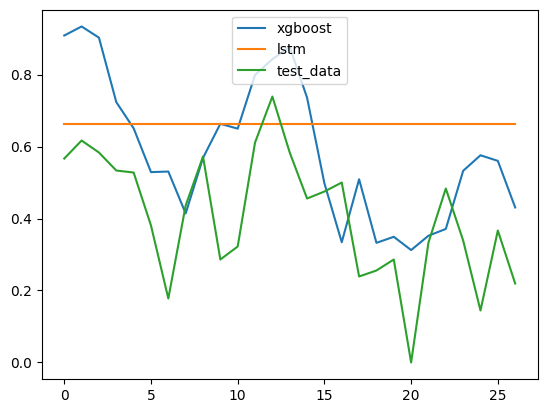

In [ ]:
plt.plot(df, label=["xgboost", "lstm", "test_data"])
leg = plt.legend(loc='upper center')